In [222]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd

plt.figure(figsize=(20,10))

%matplotlib inline

In [589]:
# pprint(gym.envs.registry.all())

In [604]:
env = gym.make('FrozenLake-v0')
# env = gym.wrappers.Monitor(env, "/tmp/gym-results")

In [593]:
env.action_space, env.observation_space

(Discrete(4), Discrete(16))

In [160]:
# type(env.action_space)

In [157]:
# dir(env.action_space)

In [156]:
# env.action_space.n

In [154]:
# env.observation_space.sample()

In [152]:
# env.observation_space.low, env.observation_space.high

In [128]:
# env.action_space.low, env.action_space.high

In [129]:
# goal 
# make a classic q-learning algorithm that runs on this environment
# then gradually expands to try all other algorithms studied
# make a common interface to my algorithms, so I can just load them in and interact with the environment
# two common interfaces should make for simple code to perform the interactions
        

In [ ]:
# program discrete cases
# then apply to continuous
# should be generic enough to cover all cases
# parametrizations need to be parameters

# there is an important distinction between observation and state that OpenAI gym observers
# not sure I need to observe in my case
# anyway, I act on current state not on observation

In [423]:

from gym import spaces
class RLAgent():
    
    def __init__(self, env):
        
        # define limits for continuous case and n for discrete case        
        if type(env.action_space) != spaces.discrete.Discrete:
            self.action_discrete = False
            self.action_high = env.action_space.low 
            self.action_low = env.action_space.high
        else:
            self.action_discrete = True
            self.action_range = env.action_space.n

        if type(env.observation_space) != spaces.discrete.Discrete:
            self.observation_discrete = False
            self.observation_high = env.observation_space.low 
            self.observation_low = env.observation_space.high
        else:
            self.observation_discrete = True
            self.observation_range = env.observation_space.n
        
        # keep track of metrics
        self.total_reward = 0
        self.rewards_per_episode = []
        
    def reset(self):
        self.rewards_per_episode.append(self.total_reward)
        self.total_reward= 0

    def act(self, current_state):
        if self.action_discrete:
            return np.random.randint(self.action_range)        
        
    def learn(self, obs, reward, done):
        pass
    
    def total_rewards(self):
        return sum(self.rewards)


class QLearning(RLAgent):
    
    def __init__(self,env, qtable_default=0, learning_rate = 0.1, exploration_rate = 0.1, 
                 epsilon_decay = True, epsilon_decay_func= lambda x: x*.99,
                 discount_factor=0.9, 
                 alpha_decay=True, alpha_decay_func = lambda x: x*.999):
        RLAgent.__init__(self, env)
        if self.action_discrete and self.observation_discrete:
            # init qtable with the default value for qtable
            # set to higher than 0 for optimistic initialization
            self.qtable={}
            for obs in range(self.observation_range):
                self.qtable[obs] = {}
                for action in range(self.action_range):
                    self.qtable[obs][action] = qtable_default
        else:
            raise TypeError("Environment not discrete.")
            
        self.learning_rate = learning_rate
        self.exploration_rate = exploration_rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_func = epsilon_decay_func
        self.alpha_decay = alpha_decay
        self.alpha_decay_func = alpha_decay_func
        self.discount_factor = discount_factor
                
    # learn and act are separate steps
    # act is just getting the argmax of qtable

    
    def reset(self):
        RLAgent.reset(self)
        
        # if set to decay, decay exploration rate according to predefined decay function
        # don't decay during planning, since it is only look ahead
        if self.epsilon_decay:
            self.exploration_rate = self.epsilon_decay_func(self.exploration_rate)
            
        if self.alpha_decay:
            self.learning_rate = self.alpha_decay_func(self.learning_rate)

    def act(self, state, look_ahead=False):        
        """ Runs argmax on qtable to define next best action """
    
        # select randomly according to a fixed exploration rate
        if np.random.rand() < self.exploration_rate and not look_ahead:
            action = np.random.randint(self.action_range)
        
        else:
            # select all possible actions
            possible_actions = list(self.qtable[state].items())

            # shuffle before sorting, to ensure randomness in case of tie
            np.random.shuffle(possible_actions)
            action = sorted(possible_actions, key=lambda x:-x[1])[0][0]
            
        return action
    
    def learn(self, prev_state, prev_action, next_state, reward, done):
        """ Update qtable. Does not return anything. 
            Independent from agent's current state, except for qtable
        """
        
        # update reward count
        self.total_reward += reward
        
        if not done:        
            # select optimal action in next step, calc td target based on it
            next_action = self.act(next_state, look_ahead=True)
            td_target = reward + self.discount_factor * self.qtable[next_state][next_action]
            
        else:
            # if final state, td target equals rewards
            td_target = reward            
            
        # update q-table
        td_error = td_target - self.qtable[prev_state][prev_action]
        self.qtable[prev_state][prev_action] += self.learning_rate * td_error 
        
    

In [583]:
def plot_rewards(ts, smoothing=0):
    smoothing = min(1, smoothing)
    window = max(1, int(len(ts)*smoothing))
    ts = pd.Series(ts).rolling(window).mean()
    plt.plot(ts)
    plt.axhline(y=0.78, linewidth=1, color='r', linestyle='dashed')


In [599]:
# env.reset()
# env.render()
# observation, reward, done, info = env.step(action)

episodes = int(1e3)
epsilon_decay = 1-(1/episodes)*6
learning_decay = 1-(1/episodes)*3
agent = QLearning(env, learning_rate =0.5, discount_factor=0.9, 
                  exploration_rate=0,
                  epsilon_decay_func = lambda x: x*epsilon_decay,
                  alpha_decay_func = lambda x: x*learning_decay,
                  qtable_default=1
                 )
for _ in range(episodes):
    prev_obs = env.reset()
    agent.reset()
    done = False
    steps =0    
    while not done:
        steps+=1
        # env.render()
        action = agent.act(prev_obs)
        next_obs, reward, done, info = env.step(action)
        agent.learn(prev_obs, action, next_obs, reward, done)
        prev_obs = next_obs
    
print(np.mean(agent.rewards_per_episode))

0.583


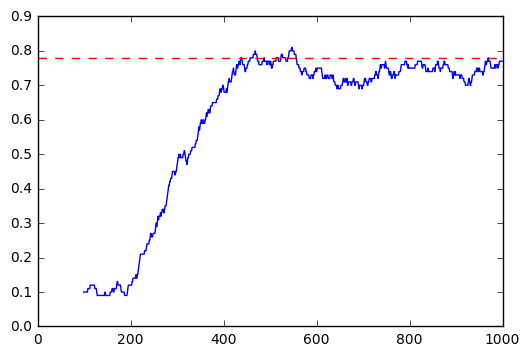

In [600]:
plot_rewards(agent.rewards_per_episode, smoothing=0.1)

In [602]:
env.close()

In [515]:
# Fixed exploration rate decay and learning rate decay according to number of episodes
# fixed the problem of not converging
# but still taking 10000 episodes to reach expected levels
# can probably reduce episodes and adjust rates accordingly

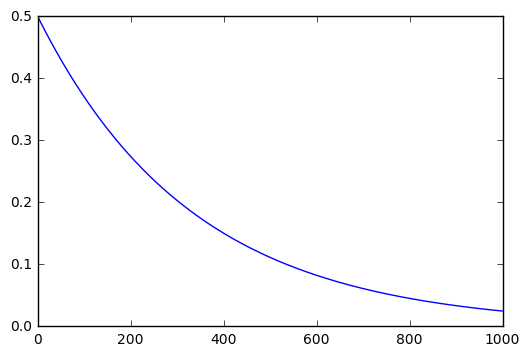

In [521]:
ts = []
lr = .5
episodes = int(1e3)
decay = 1-(1/episodes)*3
for _ in range(episodes):
    ts.append(lr)
    lr = lr*decay

plt.plot(ts)

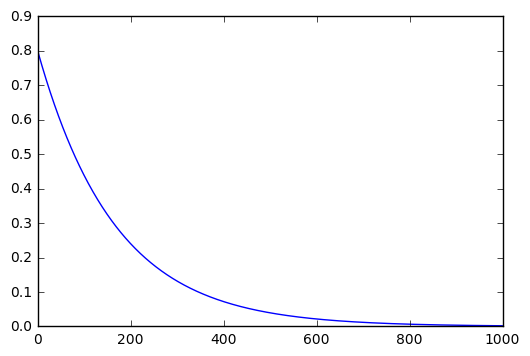

In [518]:
ts = []
lr = .8
episodes = int(1e3)
decay = 1-(1/episodes)*6
for _ in range(episodes):
    ts.append(lr)
    lr = lr*decay

plt.plot(ts)

In [ ]:
# good strategy
agent = QLearning(env, learning_rate =0.5, discount_factor=0.9, 
                  exploration_rate=0.8,
                  epsilon_decay_func = lambda x: x*.9992,
                  alpha_decay_func = lambda x: x*.9994
                 )
episodes = int(1e4)
